# Quantum Teleportation Protocol using Qiskit

This notebook implements the quantum teleportation protocol using Qiskit. The code is taken from the [homework](https://learning.quantum.ibm.com/course/basics-of-quantum-information/entanglement-in-action).
The teleportation protocol demonstrates how to transmit an unknown quantum
state from one qubit (Alice) to another (Bob) using entanglement and classical communication.

## Questions to Answer

1. Step 8: What happens to the bars in the histogram when you run the code in the Step 8 multiple times? Why?
1. Step 8: What happens to the histogram  when you increase or decrease the number of `shots`? Why?
1. What happens to Bob's qubit if `random_gate` changes to a NOT gate? Hint: use `XGate()` from `qiskit.circuit.library`.
1. What happens if Bob doesn't apply the inverse of the random gate to Bob's qubit in Step 7?

perform the conditional operations based on Alice's classical bits? How does this affect the final state of Bob's qubit?

## Setup


In [1]:
! pip install -q qiskit==1.3.1 qiskit-aer qiskit-qasm3-import pylatexenc

In [2]:
# Import necessary libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from qiskit.qasm3 import dumps, loads
from numpy import pi, random

## Implement Teleportation


### Step 1: Create the Quantum Registers and Circuit
We define three quantum registers: one for the unknown state (Q), and two for the entangled pair (A and B).
Additionally, two classical registers are created for Alice's measurement results (a, b).


In [3]:
# Create quantum and classical registers
qubit = QuantumRegister(1, "Q")      # Qubit to teleport
ebit0 = QuantumRegister(1, "A")      # Alice's qubit in the entangled pair
ebit1 = QuantumRegister(1, "B")      # Bob's qubit in the entangled pair
a = ClassicalRegister(1, "a")        # Alice's measurement result 1
b = ClassicalRegister(1, "b")        # Alice's measurement result 2

# Create the quantum circuit
protocol = QuantumCircuit(qubit, ebit0, ebit1, a, b)

### Step 2: Prepare the Entangled State
Alice and Bob share an entangled pair in the Bell state |ϕ+⟩ = (|00⟩ + |11⟩) / √2.


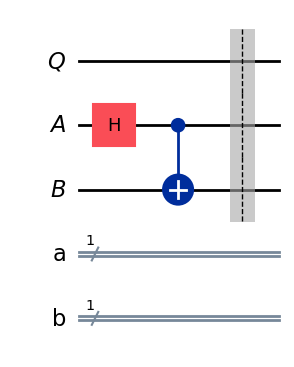

In [4]:
# Create the Bell state
protocol.h(ebit0)                   # Apply Hadamard gate on ebit0 (Alice's qubit)
protocol.cx(ebit0, ebit1)           # Apply CNOT gate with ebit0 as control and ebit1 as target
protocol.barrier()                  # Add a barrier for circuit clarity -- it's just a "cosmetic" command

# visualize the circuit so far
protocol.draw(output="mpl")

### Step 3: Alice's Operations
Alice applies a CNOT gate and a Hadamard gate to entangle her qubits (Q and A).


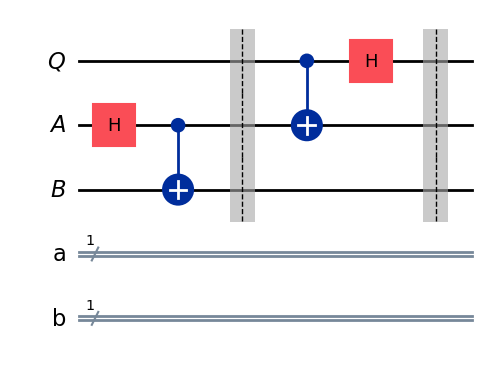

In [5]:
# Alice's operations
protocol.cx(qubit, ebit0)           # CNOT gate with Q as control and A as target
protocol.h(qubit)                   # Hadamard gate on Q
protocol.barrier()

# visualize the circuit so far
protocol.draw(output="mpl")

### Step 4: Alice's Measurements
Alice measures her qubits and sends the results (a, b) to Bob via classical communication.


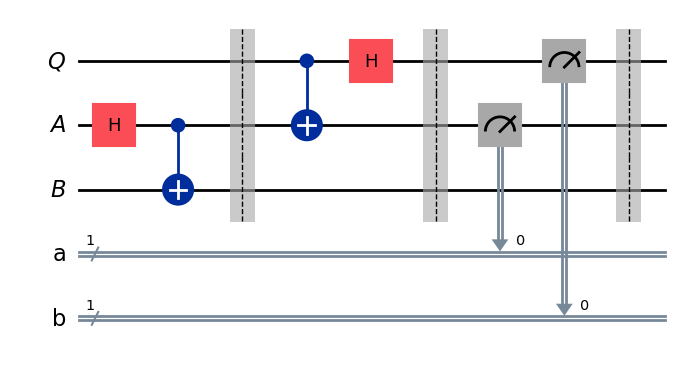

In [6]:
protocol.measure(ebit0, a)          # Measure Alice's entangled qubit
protocol.measure(qubit, b)          # Measure Alice's original qubit
protocol.barrier()

# visualize the circuit so far
protocol.draw(output="mpl")

### Step 5: Bob's Conditional Operations
Bob applies gates to his qubit (B) based on Alice's classical measurement results.


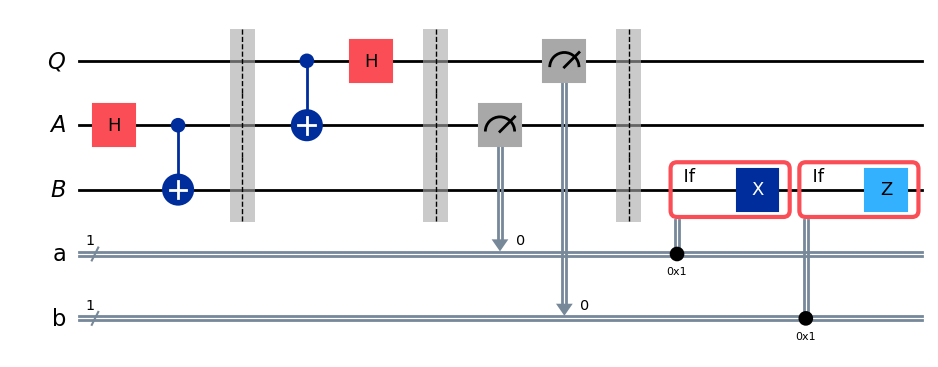

In [7]:

with protocol.if_test((a, 1)):      # Conditional X gate if a = 1
    protocol.x(ebit1)
with protocol.if_test((b, 1)):      # Conditional Z gate if b = 1
    protocol.z(ebit1)

# visualize the circuit so far
protocol.draw(output="mpl")

### Step 6: Generate a Random Quantum State
Create a random single-qubit unitary gate to prepare a random quantum state.

In [8]:
# ## Step 6: Generate a Random Quantum State
# Create a random single-qubit unitary gate to prepare a random quantum state.

random_gate = UGate(
    theta=random.random() * 2 * pi,
    phi=random.random() * 2 * pi,
    lam=random.random() * 2 * pi
)


# Display the matrix representation of the random gate
array_to_latex(random_gate.to_matrix())

<IPython.core.display.Latex object>

### Step 7: Create a Testing Circuit
This circuit applies the random gate, runs the teleportation protocol, and verifies the result.


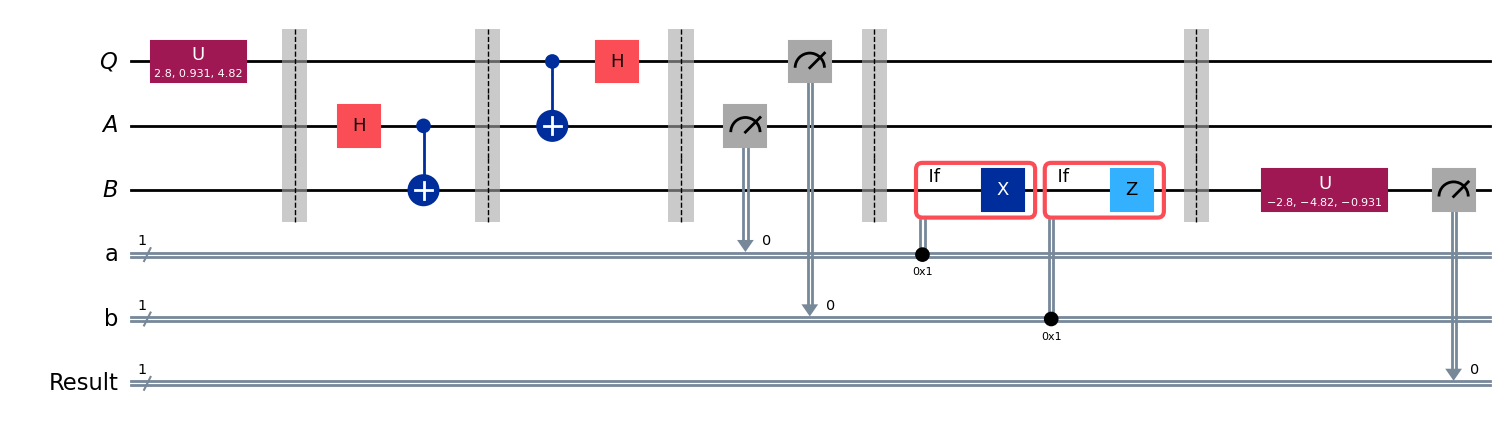

In [9]:
# Create a new circuit for testing
test = QuantumCircuit(qubit, ebit0, ebit1, a, b)

# Apply the random gate to the qubit to be teleported
test.append(random_gate, qubit)
test.barrier()

# Add the teleportation protocol
test = test.compose(protocol)
test.barrier()

# Apply the inverse of the random gate to Bob's qubit
test.append(random_gate.inverse(), ebit1)
result = ClassicalRegister(1, "Result")
test.add_register(result)
test.measure(ebit1, result)

# Visualize the testing circuit
test.draw(output="mpl")

### Step 8: Run the Simulation
Simulate the teleportation protocol and verify the result. Aer has multiple [simulation methods](https://qiskit.github.io/qiskit-aer/tutorials/1_aersimulator.html#Simulation-Method-Option). By default, it chooses the method automatically.

In [10]:
# Initialize simulator
simulator = AerSimulator(method="automatic")

# Execute the circuit
execution_result = simulator.run(test, shots=1024).result()

# Calculate probabilities
total_shots = sum(counts.values())
probabilities = {state: count / total_shots for state, count in counts.items()}

# Output raw counts and probabilities
print("Raw Distribution Data (Counts):")
print(counts)

print("\nState Probabilities:")
print(probabilities)

# Plot the measurement results
plot_histogram(counts)

NameError: name 'counts' is not defined

### Step 9: Filter the Results
Focus on the measurement result of Bob's qubit.


In [ ]:
filtered_counts = marginal_distribution(counts, [2])

# Calculate probabilities for the filtered counts
filtered_total_shots = sum(filtered_counts.values())
filtered_probabilities = {state: count / filtered_total_shots for state, count in filtered_counts.items()}

# Output filtered counts and probabilities
print("\nFiltered Distribution Data (Counts):")
print(filtered_counts)

print("\nFiltered State Probabilities:")
print(filtered_probabilities)

plot_histogram(filtered_counts)

## Porting Code Between Architectures
Don't limit yourself to a single quantum computer architecture! You can port code between architectures with relative ease, e.g., via OpenQASM.  
For more details, check the [documentation](https://docs.quantum.ibm.com/guides/interoperate-qiskit-qasm3).

In [ ]:
# Print the quantum assembly for the protocol circuit
qasm_str = dumps(test)
print(qasm_str)

Create new circuit from quantum assembly. Note that the names of the wires are a bit weird (which is not improtant from the practical perspective). The actual circuit is identical to the one above.


In [ ]:
# Create new circuit from quantum assembly
# Note that the names of the wires are a bit weird (which is not improtant from the practical perspective)
# The rest is identical
new_circuit = loads(qasm_str)
new_circuit.draw("mpl")

A caveat: Currently, Pennylane can only process OpenQASM 2.0 code. However, OpenQASM 2.0 does not support `if`-statements.

In [ ]:
from qiskit import qasm2
print(qasm2.dumps(test))